In [2]:
%%bash
apt-get -y install libopenjp2-7-dev libopenjp2-tools openslide-tools libpixman-1-dev | tail -n 1
pip install git+https://github.com/TissueImageAnalytics/tiatoolbox.git@develop | tail -n 1
echo "Installation is done."


Installation is done.


  Running command git clone --filter=blob:none --quiet https://github.com/TissueImageAnalytics/tiatoolbox.git /tmp/pip-req-build-awedq9h3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
bigframes 0.18.0 requires pandas<2.1.4,>=1.5.0, but you have pandas 2.1.4 which is incompatible.
google-colab 1.0.0 requires pandas==1.5.3, but you have pandas 2.1.4 which is incompatible.
notebook 6.5.5 requires jupyter-client<8,>=5.3.4, but you have jupyter-client 8.6.0 which is incompatible.
notebook 6.5.5 requires pyzmq<25,>=17, but you have pyzmq 25.1.2 which is incompatible.


In [3]:
"""Import modules required to run the Jupyter notebook."""
from __future__ import annotations

# Clear logger to use tiatoolbox.logger
import logging

if logging.getLogger().hasHandlers():
    logging.getLogger().handlers.clear()

import shutil
import warnings
from pathlib import Path

import joblib
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from tiatoolbox import logger
from tiatoolbox.models.engine.multi_task_segmentor import MultiTaskSegmentor
from tiatoolbox.utils.misc import download_data, imread

# We need this function to visualize the nuclear predictions
from tiatoolbox.utils.visualization import (
    overlay_prediction_contours,
    overlay_prediction_mask,
)
from tiatoolbox.wsicore.wsireader import WSIReader

mpl.rcParams["figure.dpi"] = 300  # for high resolution figure in notebook
mpl.rcParams["figure.facecolor"] = "white"  # To make sure text is visible in dark mode
warnings.filterwarnings("ignore")

|2024-01-10|11:58:57.519| [INFO] NumExpr defaulting to 2 threads.


In [4]:
ON_GPU = True  # Default is True.


In [9]:
warnings.filterwarnings("ignore")


def renew_dir(dir_path: str | Path) -> None:
    """Delete any tmp directory and create a new tmp."""
    if Path(dir_path).is_dir():
        shutil.rmtree(dir_path)
        logger.info("Deleting %s", dir_path)
    Path(dir_path).mkdir()
    logger.info("Creating new %s", dir_path)


global_save_dir = Path("./tmp/")
renew_dir(global_save_dir)

|2024-01-10|12:01:09.573| [INFO] Deleting tmp
|2024-01-10|12:01:09.575| [INFO] Creating new tmp


In [10]:
# These file name are used for
img_file_name = global_save_dir / "test2.png"
wsi_file_name = global_save_dir / "sample_wsi.svs"

logger.info("Download has started. Please wait...")

# # Downloading sample image tile
# download_data(
#     "https://tiatoolbox.dcs.warwick.ac.uk/sample_imgs/tcga_hnscc.png",
#     img_file_name,
# )

# Downloading sample whole-slide image
download_data(
    "https://tiatoolbox.dcs.warwick.ac.uk/testdata/models/samples/wsi2_4k_4k.svs",
    wsi_file_name,
)

logger.info("Download is complete.")

|2024-01-10|12:02:07.043| [INFO] Download has started. Please wait...
|2024-01-10|12:02:07.351| [INFO] Download is complete.


In [11]:
# Tile prediction
multi_segmentor = MultiTaskSegmentor(
    pretrained_model="hovernetplus-oed",
    num_loader_workers=0,
    num_postproc_workers=0,
    batch_size=4,
)

tile_output = multi_segmentor.predict(
    [img_file_name],
    save_dir=global_save_dir / "sample_tile_results",
    mode="tile",
    on_gpu=ON_GPU,
    crash_on_exception=True,
)

|2024-01-10|12:02:10.683| [WARNING] WSIPatchDataset only reads image tile at `units="baseline"`. Resolutions will be converted to baseline value.
|2024-01-10|12:02:10.798| [WARNING] WSIPatchDataset only reads image tile at `units="baseline"`. Resolutions will be converted to baseline value.
|2024-01-10|12:02:10.883| [WARNING] Raw data is None.
|2024-01-10|12:02:10.885| [WARNING] Unknown scale (no objective_power or mpp)
Process Batch: 100%|##############################| 4/4 [00:02<00:00,  1.73it/s]

|2024-01-10|12:02:33.720| [INFO] Finish: 0
|2024-01-10|12:02:33.721| [INFO] --Input: tmp/test2.png
|2024-01-10|12:02:33.723| [INFO] --Output: /content/tmp/sample_tile_results/0


|2024-01-10|12:02:33.800| [INFO] Number of detected nuclei: 53.
|2024-01-10|12:02:33.801| [INFO] Processed prediction dimensions: (1072, 2016)
|2024-01-10|12:02:33.804| [INFO] Prediction method output is: tmp/test2.png, /content/tmp/sample_tile_results/0,
|2024-01-10|12:02:33.863| [INFO] Input image dimensions: (1072, 2016, 3)


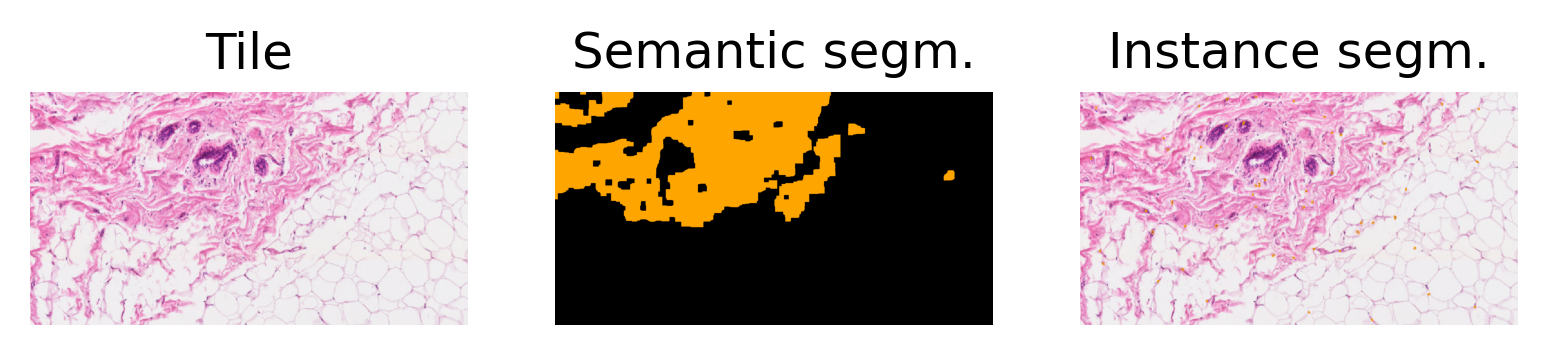

In [12]:
inst_dict = joblib.load(f"{tile_output[0][1]}.0.dat")
layer_map = np.load(f"{tile_output[0][1]}.1.npy")
logger.info("Number of detected nuclei: %d.", len(inst_dict))
logger.info(
    "Processed prediction dimensions: (%d, %d)",
    layer_map.shape[0],
    layer_map.shape[1],
)
logger.info(
    "Prediction method output is: %s, %s,",
    tile_output[0][0],
    tile_output[0][1],
)

# showing the predicted semantic segmentation
tile = imread(img_file_name)
logger.info(
    "Input image dimensions: (%d, %d, %d)",
    tile.shape[0],
    tile.shape[1],
    tile.shape[2],
)

semantic_color_dict = {
    0: ("Background", (0, 0, 0)),
    1: ("Other", (255, 165, 0)),
    2: ("Basal", (255, 0, 0)),
    3: ("Epithelial", (0, 255, 0)),
    4: ("Keratin", (0, 0, 255)),
}

inst_color_dict = {
    0: ("Background", (0, 0, 0)),
    1: ("Other", (255, 165, 0)),
    2: ("Epithelium", (255, 0, 0)),
}

# Create the overlay image
overlaid_predictions_inst = overlay_prediction_contours(
    canvas=tile,
    inst_dict=inst_dict,
    draw_dot=False,
    type_colours=inst_color_dict,
    line_thickness=2,
)

# Create the semantic segmentation image (in colour)
semantic_map = np.zeros((layer_map.shape[0], layer_map.shape[1], 3)).astype("uint8")
for idx, (_label, color) in semantic_color_dict.items():
    semantic_map[layer_map == idx] = color

# showing processed results alongside the original images
fig2 = plt.figure()
ax1 = plt.subplot(1, 3, 1), plt.imshow(tile), plt.axis("off"), plt.title("Tile")
ax2 = (
    plt.subplot(1, 3, 2),
    plt.imshow(semantic_map),
    plt.axis("off"),
    plt.title("Semantic segm."),
)
ax3 = (
    plt.subplot(1, 3, 3),
    plt.imshow(overlaid_predictions_inst),
    plt.axis("off"),
    plt.title("Instance segm."),
)